Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.3529 | val 0.4258
Epoch 2/100: train 0.1564 | val 0.1449
Epoch 3/100: train 0.1163 | val 0.1151
Epoch 4/100: train 0.1083 | val 0.0981
Epoch 5/100: train 0.0970 | val 0.1090
Epoch 6/100: train 0.0899 | val 0.0819
Epoch 7/100: train 0.0865 | val 0.0567
Epoch 8/100: train 0.0762 | val 0.1074
Epoch 9/100: train 0.0862 | val 0.1231
Epoch 10/100: train 0.0764 | val 0.0692
Epoch 11/100: train 0.0763 | val 0.0806
Epoch 12/100: train 0.0801 | val 0.0605
Epoch 13/100: train 0.0778 | val 0.0579
Epoch 14/100: train 0.0667 | val 0.0533
Epoch 15/100: train 0.0751 | val 0.0635
Epoch 16/100: train 0.0707 | val 0.0453
Epoch 17/100: train 0.0726 | val 0.0507
Epoch 18/100: train 0.0734 | val 0.0591
Epoch 19/100: train 0.0692 | val 0.0796
Epoch 20/100: train 0.0697 | val 0.0650
Epoch 21/100: train 0.0690 | val 0.0568
Epoch 22/100: train 0.0

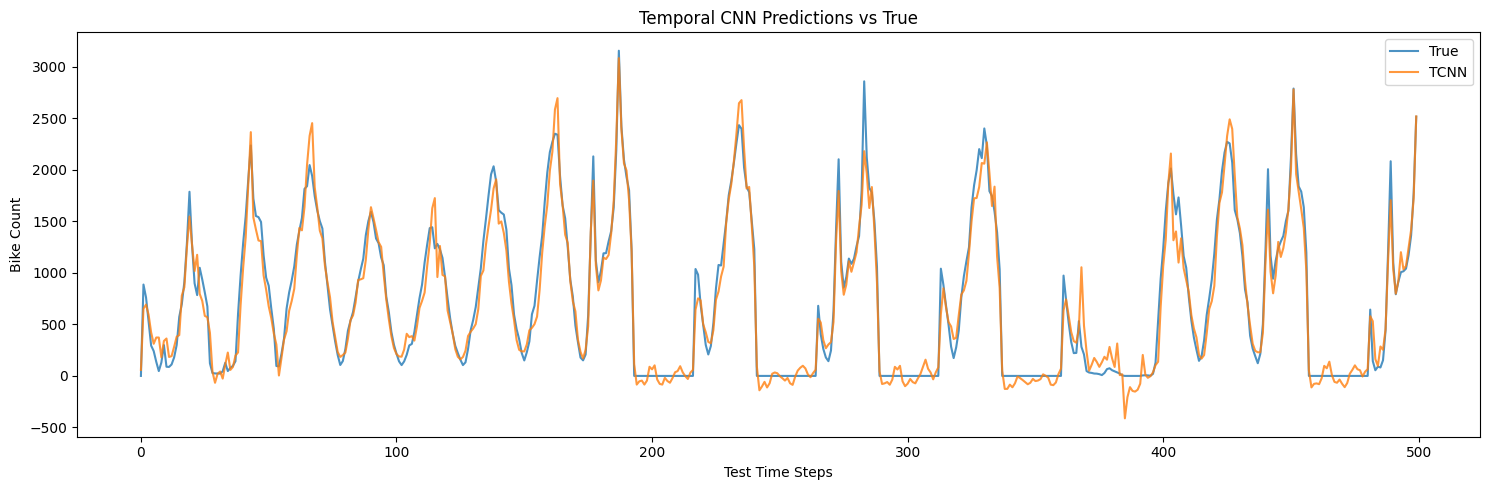

Temporal CNN training complete!


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=64, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=64, dropout=0.3).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")


changing lr and or dropout

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.3397 | val 0.2825
Epoch 2/100: train 0.1333 | val 0.1103
Epoch 3/100: train 0.1021 | val 0.1482
Epoch 4/100: train 0.0861 | val 0.0773
Epoch 5/100: train 0.0774 | val 0.0745
Epoch 6/100: train 0.0799 | val 0.0706
Epoch 7/100: train 0.0694 | val 0.0598
Epoch 8/100: train 0.0619 | val 0.0574
Epoch 9/100: train 0.0686 | val 0.0539
Epoch 10/100: train 0.0617 | val 0.0507
Epoch 11/100: train 0.0636 | val 0.0593
Epoch 12/100: train 0.0619 | val 0.0519
Epoch 13/100: train 0.0644 | val 0.0761
Epoch 14/100: train 0.0617 | val 0.0536
Epoch 15/100: train 0.0611 | val 0.0489
Epoch 16/100: train 0.0565 | val 0.0495
Epoch 17/100: train 0.0621 | val 0.0612
Epoch 18/100: train 0.0584 | val 0.0537
Epoch 19/100: train 0.0572 | val 0.0682
Epoch 20/100: train 0.0591 | val 0.0607
Epoch 21/100: train 0.0562 | val 0.0420
Epoch 22/100: train 0.0

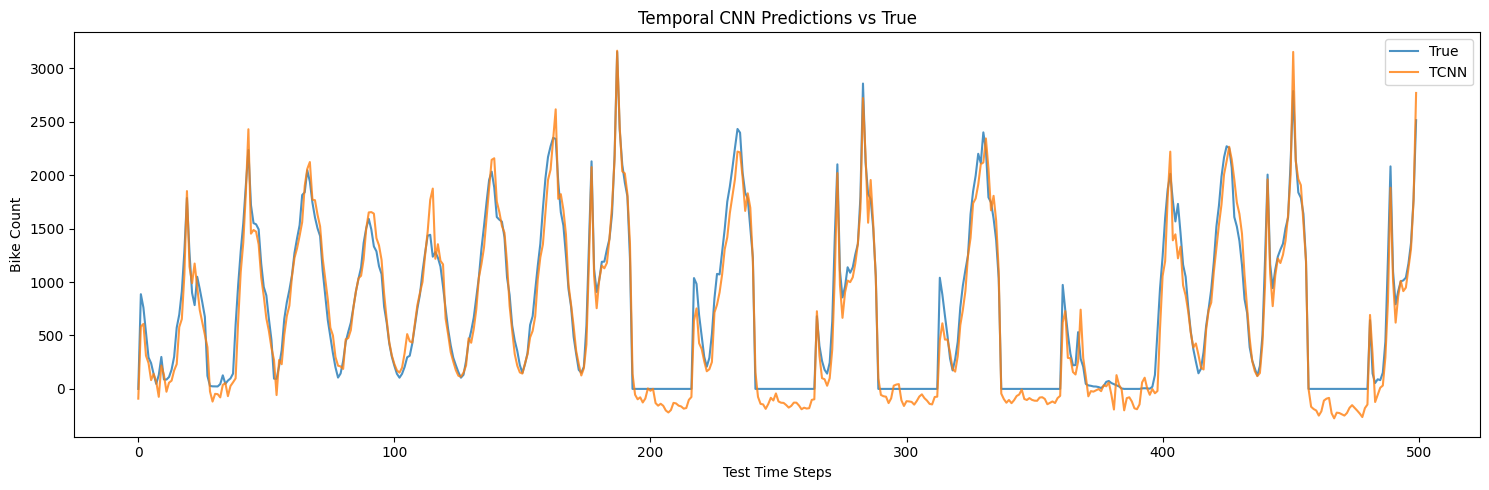

Temporal CNN training complete!


In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=64, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=64, dropout=0.2).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")


Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.5724 | val 0.6685
Epoch 2/100: train 0.3543 | val 0.4550
Epoch 3/100: train 0.2492 | val 0.3520
Epoch 4/100: train 0.2012 | val 0.3438
Epoch 5/100: train 0.1742 | val 0.2531
Epoch 6/100: train 0.1472 | val 0.2409
Epoch 7/100: train 0.1240 | val 0.2809
Epoch 8/100: train 0.1138 | val 0.1895
Epoch 9/100: train 0.1029 | val 0.1860
Epoch 10/100: train 0.1005 | val 0.1831
Epoch 11/100: train 0.0880 | val 0.1544
Epoch 12/100: train 0.0871 | val 0.1855
Epoch 13/100: train 0.0816 | val 0.1524
Epoch 14/100: train 0.0838 | val 0.2175
Epoch 15/100: train 0.0717 | val 0.1847
Epoch 16/100: train 0.0722 | val 0.1200
Epoch 17/100: train 0.0700 | val 0.1206
Epoch 18/100: train 0.0682 | val 0.1151
Epoch 19/100: train 0.0694 | val 0.1415
Epoch 20/100: train 0.0635 | val 0.1529
Epoch 21/100: train 0.0627 | val 0.1157
Epoch 22/100: train 0.0

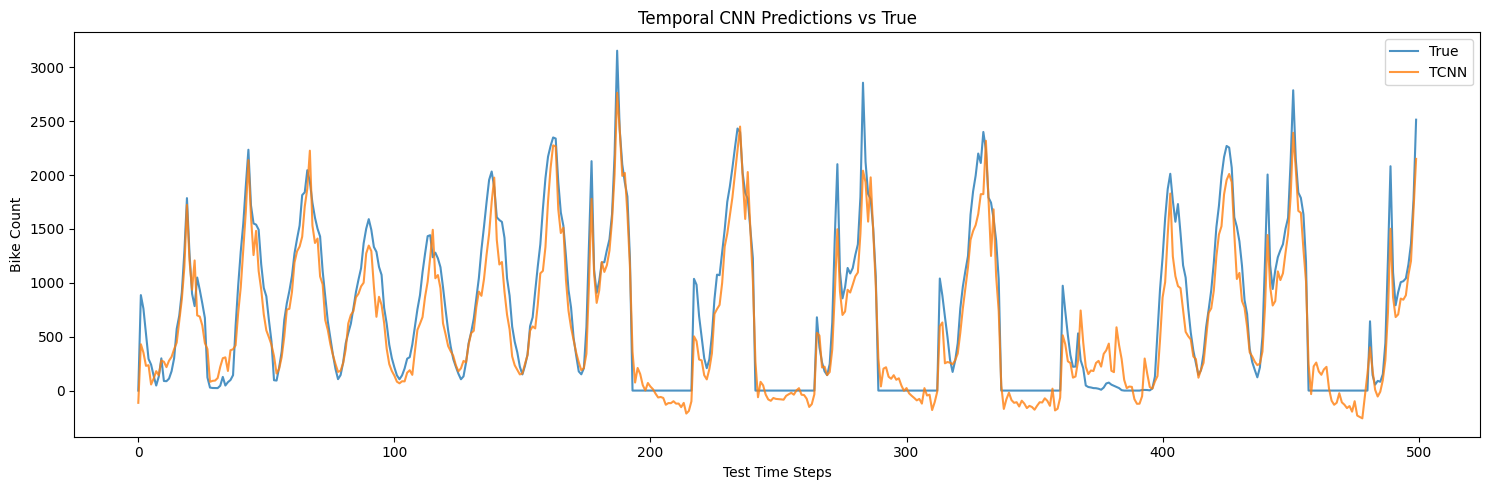

Temporal CNN training complete!


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=64, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=64, dropout=0.2).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")


Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.5923 | val 0.6520
Epoch 2/100: train 0.3444 | val 0.4983
Epoch 3/100: train 0.2585 | val 0.4176
Epoch 4/100: train 0.2125 | val 0.3693
Epoch 5/100: train 0.1843 | val 0.3417
Epoch 6/100: train 0.1638 | val 0.2714
Epoch 7/100: train 0.1416 | val 0.2312
Epoch 8/100: train 0.1411 | val 0.2476
Epoch 9/100: train 0.1262 | val 0.1948
Epoch 10/100: train 0.1134 | val 0.2564
Epoch 11/100: train 0.1083 | val 0.2290
Epoch 12/100: train 0.1022 | val 0.1646
Epoch 13/100: train 0.0913 | val 0.1666
Epoch 14/100: train 0.0864 | val 0.1637
Epoch 15/100: train 0.0867 | val 0.1511
Epoch 16/100: train 0.0842 | val 0.1570
Epoch 17/100: train 0.0800 | val 0.1659
Epoch 18/100: train 0.0742 | val 0.1462
Epoch 19/100: train 0.0759 | val 0.1144
Epoch 20/100: train 0.0678 | val 0.1149
Epoch 21/100: train 0.0733 | val 0.1436
Epoch 22/100: train 0.0

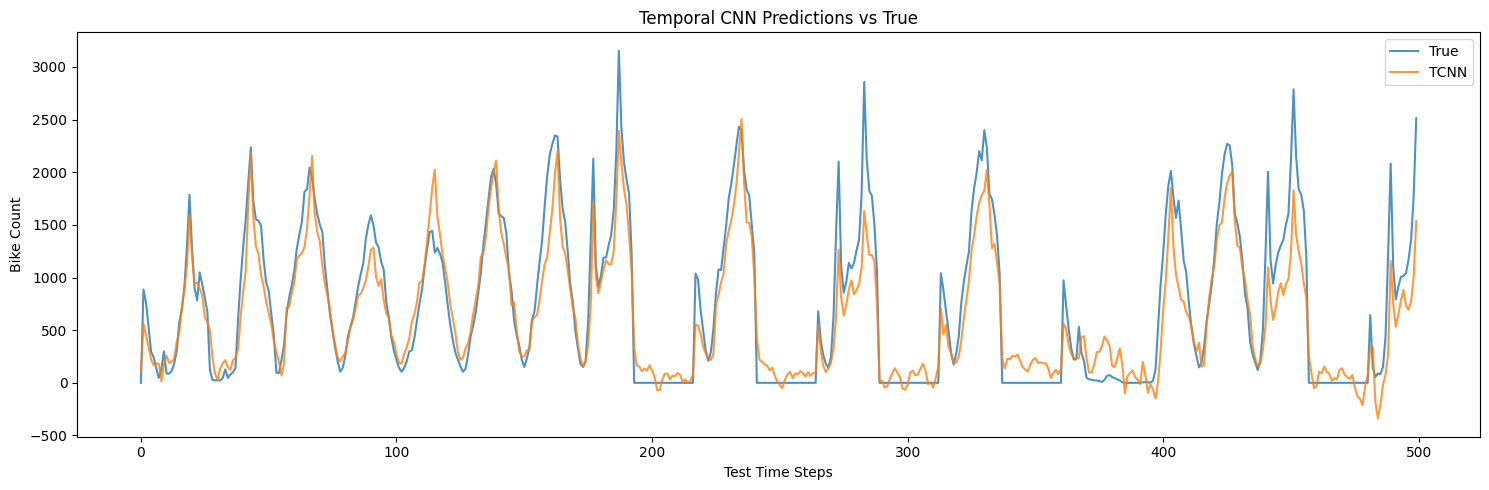

Temporal CNN training complete!


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=64, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=64, dropout=0.3).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")


changing with lr and sropout didnot improve the model so adding another conv layer

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.3440 | val 0.3061
Epoch 2/100: train 0.1434 | val 0.1113
Epoch 3/100: train 0.1009 | val 0.0666
Epoch 4/100: train 0.0858 | val 0.0714
Epoch 5/100: train 0.0806 | val 0.0974
Epoch 6/100: train 0.0808 | val 0.1370
Epoch 7/100: train 0.0746 | val 0.0593
Epoch 8/100: train 0.0671 | val 0.0587
Epoch 9/100: train 0.0695 | val 0.0788
Epoch 10/100: train 0.0687 | val 0.0509
Epoch 11/100: train 0.0727 | val 0.0533
Epoch 12/100: train 0.0653 | val 0.0601
Epoch 13/100: train 0.0653 | val 0.0563
Epoch 14/100: train 0.0626 | val 0.0887
Epoch 15/100: train 0.0618 | val 0.0769
Epoch 16/100: train 0.0617 | val 0.0931
Epoch 17/100: train 0.0564 | val 0.0822
Epoch 18/100: train 0.0629 | val 0.0627
Epoch 19/100: train 0.0567 | val 0.0619
Epoch 20/100: train 0.0584 | val 0.0495
Epoch 21/100: train 0.0583 | val 0.0613
Epoch 22/100: train 0.0

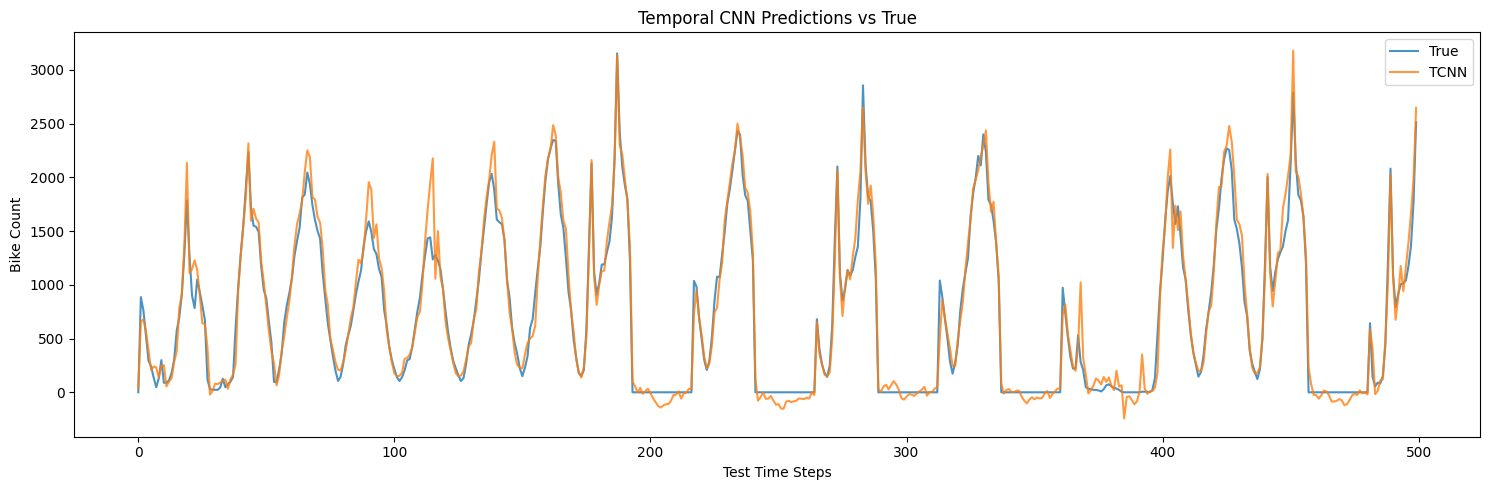

Temporal CNN training complete!


In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=64, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        x = torch.relu(self.conv4(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=64, dropout=0.3).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")


Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.3272 | val 0.2466
Epoch 2/100: train 0.1380 | val 0.2145
Epoch 3/100: train 0.1066 | val 0.2163
Epoch 4/100: train 0.0934 | val 0.0826
Epoch 5/100: train 0.0861 | val 0.0669
Epoch 6/100: train 0.0782 | val 0.0630
Epoch 7/100: train 0.0768 | val 0.0850
Epoch 8/100: train 0.0794 | val 0.1415
Epoch 9/100: train 0.0777 | val 0.0579
Epoch 10/100: train 0.0792 | val 0.0862
Epoch 11/100: train 0.0695 | val 0.0736
Epoch 12/100: train 0.0715 | val 0.0865
Epoch 13/100: train 0.0680 | val 0.0612
Epoch 14/100: train 0.0712 | val 0.0793
Epoch 15/100: train 0.0691 | val 0.0507
Epoch 16/100: train 0.0730 | val 0.0708
Epoch 17/100: train 0.0611 | val 0.0532
Epoch 18/100: train 0.0627 | val 0.0481
Epoch 19/100: train 0.0579 | val 0.0492
Epoch 20/100: train 0.0654 | val 0.0516
Epoch 21/100: train 0.0594 | val 0.0486
Epoch 22/100: train 0.0

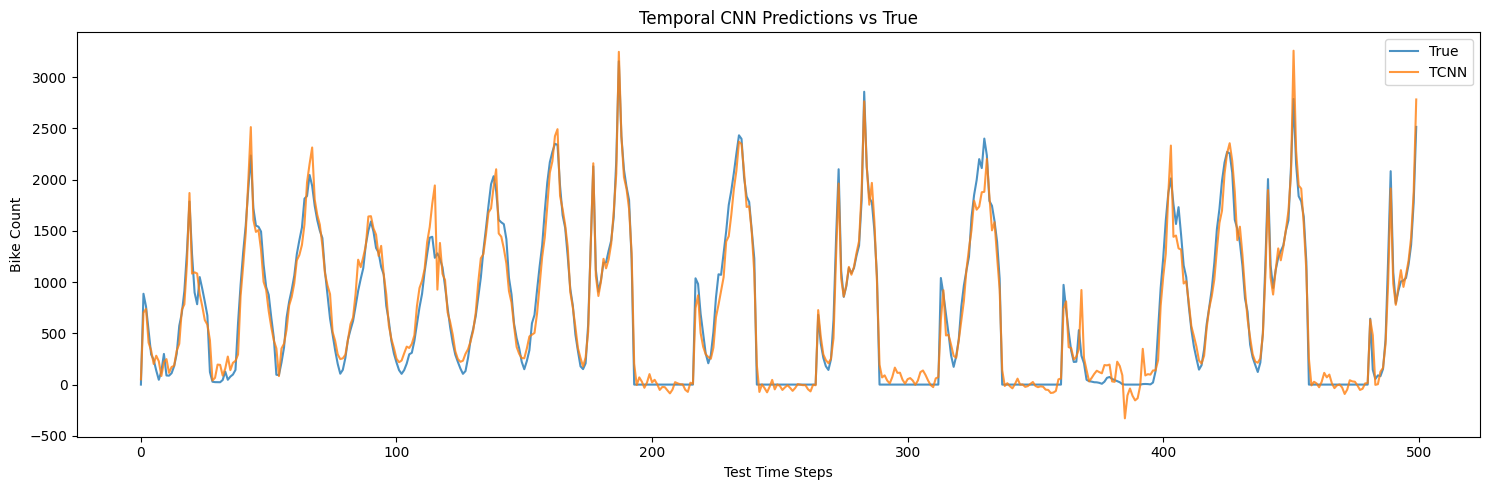

Temporal CNN training complete!


In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        # self.conv4 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        # x = torch.relu(self.conv4(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")


Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.3065 | val 0.1608
Epoch 2/100: train 0.1102 | val 0.0969
Epoch 3/100: train 0.0912 | val 0.0942
Epoch 4/100: train 0.0812 | val 0.0684
Epoch 5/100: train 0.0777 | val 0.0691
Epoch 6/100: train 0.0717 | val 0.0991
Epoch 7/100: train 0.0706 | val 0.0728
Epoch 8/100: train 0.0750 | val 0.0572
Epoch 9/100: train 0.0709 | val 0.0633
Epoch 10/100: train 0.0720 | val 0.0557
Epoch 11/100: train 0.0677 | val 0.0504
Epoch 12/100: train 0.0634 | val 0.0448
Epoch 13/100: train 0.0655 | val 0.0633
Epoch 14/100: train 0.0600 | val 0.0494
Epoch 15/100: train 0.0671 | val 0.0674
Epoch 16/100: train 0.0645 | val 0.0595
Epoch 17/100: train 0.0608 | val 0.0594
Epoch 18/100: train 0.0616 | val 0.0516
Epoch 19/100: train 0.0604 | val 0.0549
Epoch 20/100: train 0.0579 | val 0.0540
Epoch 21/100: train 0.0566 | val 0.0530
Epoch 22/100: train 0.0

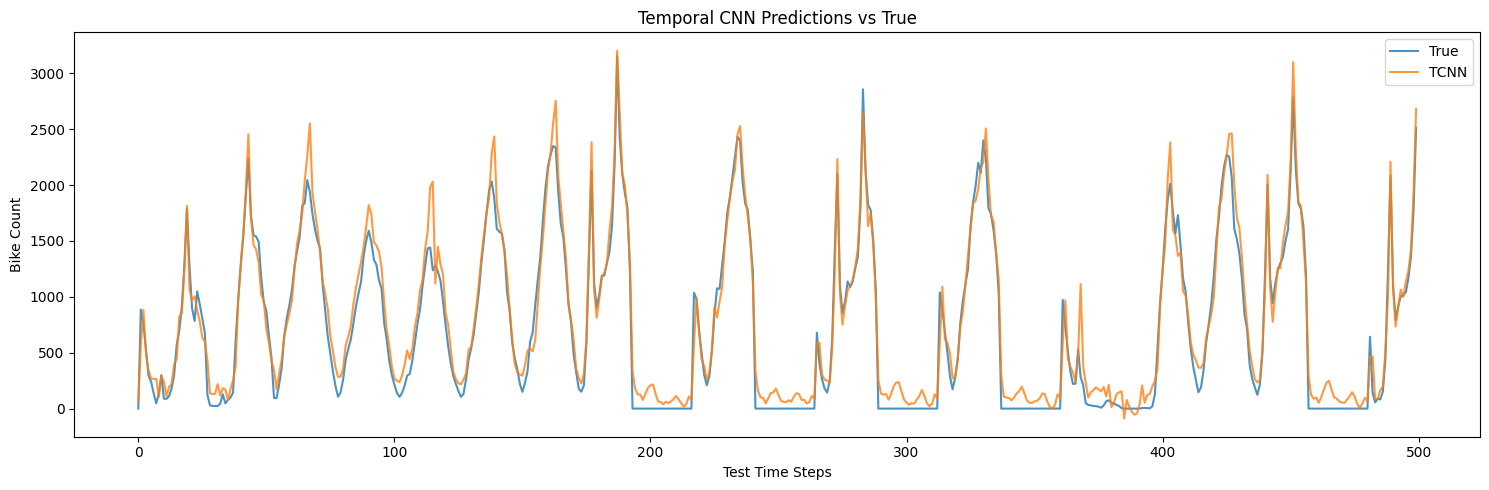

Temporal CNN training complete!


In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=96, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        # self.conv4 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        # x = torch.relu(self.conv4(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=96, dropout=0.3).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")


changing the channles to 80 improved teh accuracy so now going to change the lr

Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.3560 | val 0.2818
Epoch 2/100: train 0.1500 | val 0.1682
Epoch 3/100: train 0.1079 | val 0.0939
Epoch 4/100: train 0.0984 | val 0.1056
Epoch 5/100: train 0.0935 | val 0.0583
Epoch 6/100: train 0.0867 | val 0.0504
Epoch 7/100: train 0.0802 | val 0.1117
Epoch 8/100: train 0.0748 | val 0.0684
Epoch 9/100: train 0.0788 | val 0.0582
Epoch 10/100: train 0.0872 | val 0.0584
Epoch 11/100: train 0.0708 | val 0.0655
Epoch 12/100: train 0.0752 | val 0.0701
Epoch 13/100: train 0.0752 | val 0.0583
Epoch 14/100: train 0.0691 | val 0.0756
Epoch 15/100: train 0.0745 | val 0.0453
Epoch 16/100: train 0.0714 | val 0.0628
Epoch 17/100: train 0.0746 | val 0.0491
Epoch 18/100: train 0.0748 | val 0.0430
Epoch 19/100: train 0.0637 | val 0.0447
Epoch 20/100: train 0.0704 | val 0.0476
Epoch 21/100: train 0.0690 | val 0.0581
Epoch 22/100: train 0.0

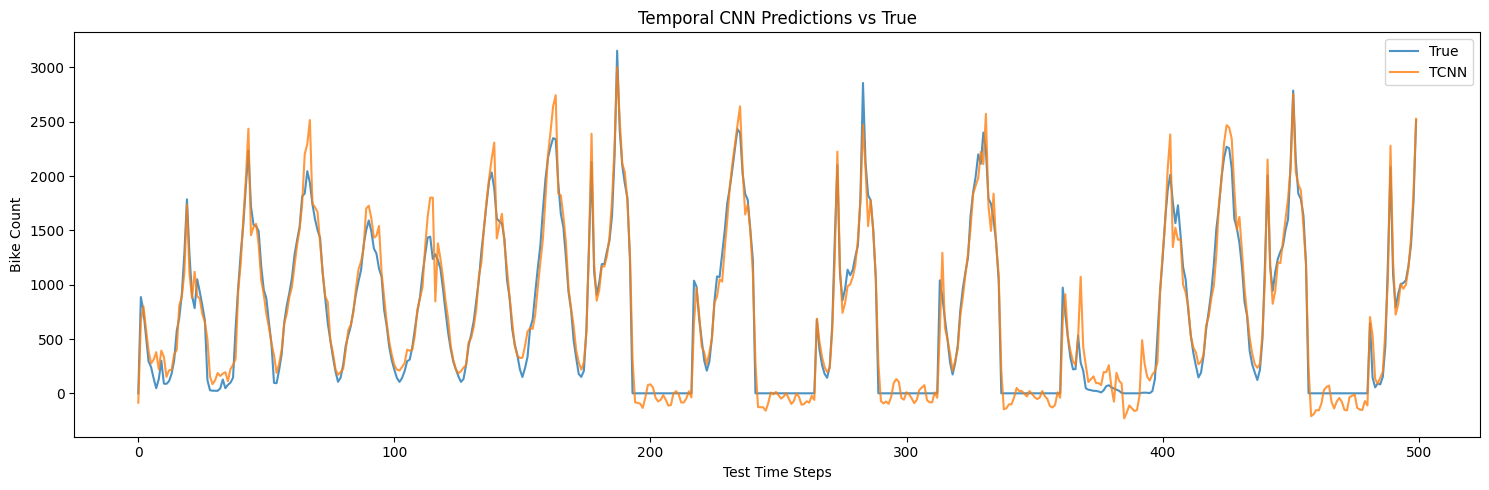

Temporal CNN training complete!


In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        # self.conv4 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        # x = torch.relu(self.conv4(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=2e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")


Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.3291 | val 0.2768
Epoch 2/100: train 0.1552 | val 0.1658
Epoch 3/100: train 0.1118 | val 0.1161
Epoch 4/100: train 0.0947 | val 0.0894
Epoch 5/100: train 0.0918 | val 0.0670
Epoch 6/100: train 0.0859 | val 0.0606
Epoch 7/100: train 0.0815 | val 0.0553
Epoch 8/100: train 0.0810 | val 0.0501
Epoch 9/100: train 0.0838 | val 0.0730
Epoch 10/100: train 0.0839 | val 0.0564
Epoch 11/100: train 0.0843 | val 0.0606
Epoch 12/100: train 0.0838 | val 0.0498
Epoch 13/100: train 0.0854 | val 0.0530
Epoch 14/100: train 0.0800 | val 0.0562
Epoch 15/100: train 0.0745 | val 0.0537
Epoch 16/100: train 0.0791 | val 0.0510
Epoch 17/100: train 0.0731 | val 0.0502
Epoch 18/100: train 0.0729 | val 0.0533
Epoch 19/100: train 0.0760 | val 0.0492
Epoch 20/100: train 0.0749 | val 0.0580
Epoch 21/100: train 0.0706 | val 0.0487
Epoch 22/100: train 0.0

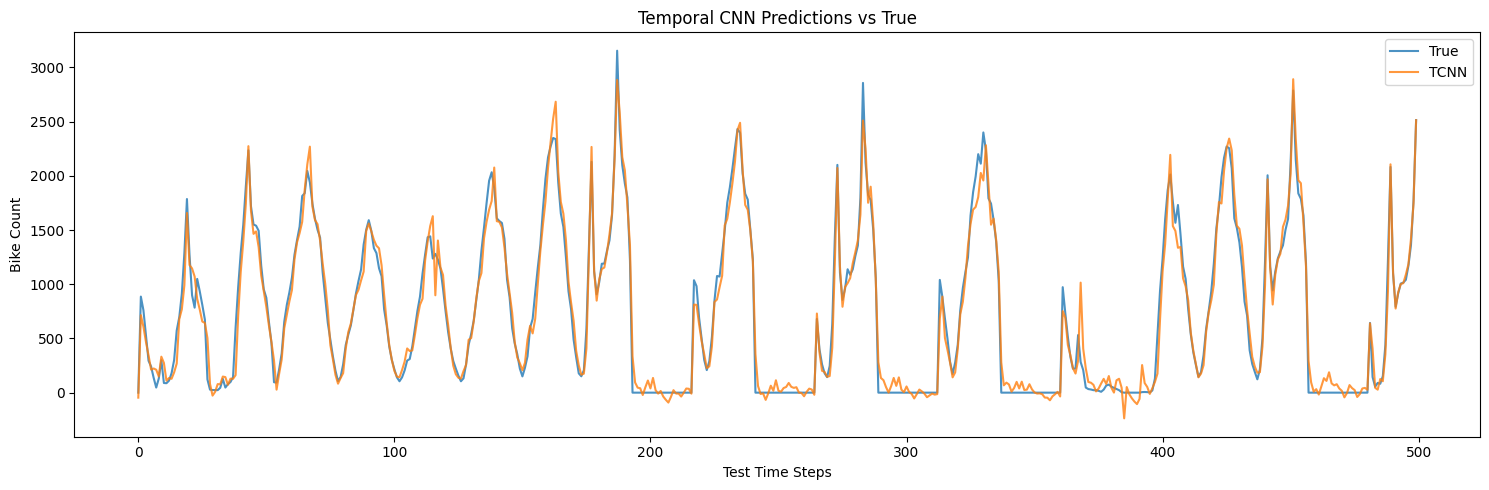

Temporal CNN training complete!


In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        # self.conv4 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        # x = torch.relu(self.conv4(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")


Training on 5934 train sequences, 1047 val sequences
Sequence shape: (5934, 24, 20), features: 20
TemporalCNN: input 20 feats -> 64 conv channels
Epoch 1/100: train 0.5576 | val 0.6535
Epoch 2/100: train 0.3340 | val 0.4752
Epoch 3/100: train 0.2276 | val 0.3042
Epoch 4/100: train 0.1806 | val 0.2489
Epoch 5/100: train 0.1499 | val 0.2358
Epoch 6/100: train 0.1266 | val 0.2741
Epoch 7/100: train 0.1072 | val 0.1380
Epoch 8/100: train 0.0968 | val 0.1595
Epoch 9/100: train 0.0885 | val 0.2024
Epoch 10/100: train 0.0833 | val 0.1574
Epoch 11/100: train 0.0765 | val 0.1571
Epoch 12/100: train 0.0720 | val 0.1202
Epoch 13/100: train 0.0716 | val 0.1492
Epoch 14/100: train 0.0689 | val 0.1095
Epoch 15/100: train 0.0673 | val 0.0814
Epoch 16/100: train 0.0640 | val 0.0941
Epoch 17/100: train 0.0645 | val 0.0911
Epoch 18/100: train 0.0651 | val 0.0938
Epoch 19/100: train 0.0619 | val 0.1150
Epoch 20/100: train 0.0609 | val 0.1063
Epoch 21/100: train 0.0584 | val 0.1007
Epoch 22/100: train 0.0

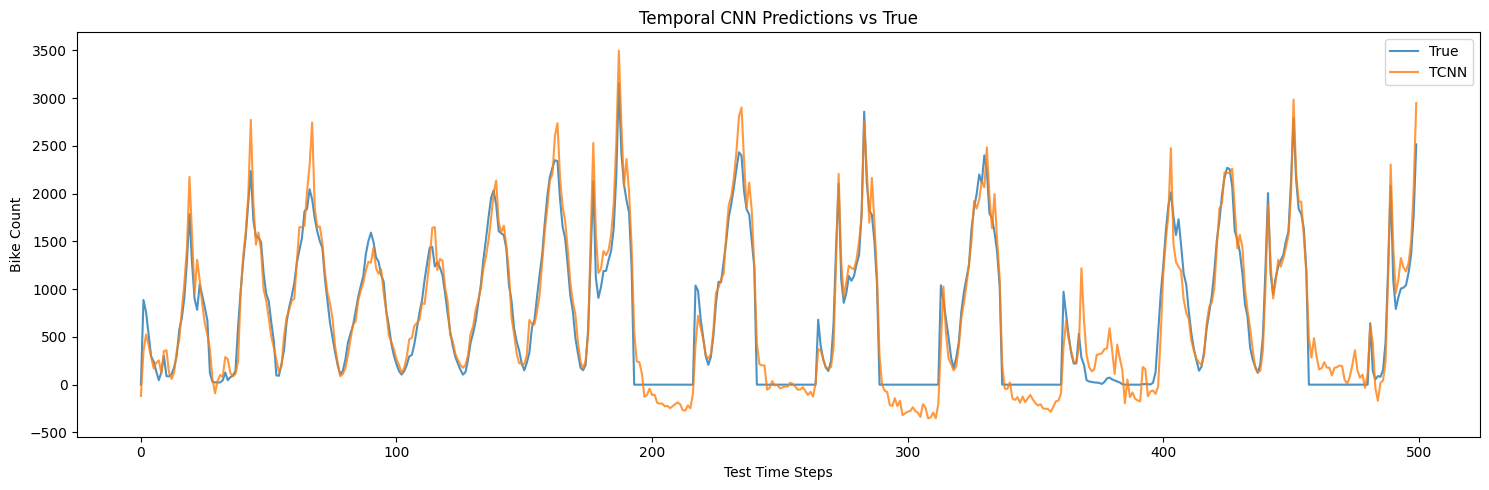

Temporal CNN training complete!


In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Early stopping helper ----
class EarlyStopper:
    def __init__(self, patience=10, min_delta=1e-4):
        self.patience = patience
        self.min_delta = min_delta
        self.best = float('inf')
        self.counter = 0

    def step(self, val_loss):
        if val_loss < self.best - self.min_delta:
            self.best = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            return self.counter >= self.patience

def evaluate_loss(model, loader, criterion, device):
    model.eval()
    losses = []
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            loss = criterion(preds, yb)
            losses.append(loss.item())
    return np.mean(losses)

# --- 1-5. Data Prep (UNCHANGED) ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    # Add cyclical encoding
    df['hour_sin'] = np.sin(2 * np.pi * df['Hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Hour']/24)
    df['day_sin'] = np.sin(2 * np.pi * df['DayOfWeek']/7)
    df['day_cos'] = np.cos(2 * np.pi * df['DayOfWeek']/7)

    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# 80/20 chronological split
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)  # 80% here
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# Feature selection with XGBoost
xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# Scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

def create_sequences(X, y, seq_len=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len-1])
    return np.array(X_seq, dtype=np.float32), np.array(y_seq, dtype=np.float32)

seq_len = 24
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_len)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, seq_len)

n_features = X_train_seq.shape[2]
X_test_torch = torch.from_numpy(X_test_seq)
y_test_torch = torch.from_numpy(y_test_seq).unsqueeze(1)

# ---- Train/Val split from training sequences ----
val_ratio = 0.15
val_size = int(len(X_train_seq) * val_ratio)

X_tr_seq = X_train_seq[:-val_size]
y_tr_seq = y_train_seq[:-val_size]
X_val_seq = X_train_seq[-val_size:]
y_val_seq = y_train_seq[-val_size:]

X_tr_torch = torch.from_numpy(X_tr_seq)
y_tr_torch = torch.from_numpy(y_tr_seq).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_seq)
y_val_torch = torch.from_numpy(y_val_seq).unsqueeze(1)

train_dataset = TensorDataset(X_tr_torch, y_tr_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Training on {X_tr_seq.shape[0]} train sequences, {X_val_seq.shape[0]} val sequences")
print(f"Sequence shape: {X_tr_seq.shape}, features: {n_features}")

# --- Temporal CNN (TCNN) architecture ---
class TemporalCNN(nn.Module):
    def __init__(self, input_size, channels=80, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv1d(input_size, channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        # self.conv4 = nn.Conv1d(channels, channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm1d(channels)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(channels, 1)

    def forward(self, x):
        # x: [B, T, F]
        x = x.transpose(1, 2)              # [B, F, T]
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = torch.relu(self.conv3(x))
        # x = torch.relu(self.conv4(x))
        x = self.bn(x)
        x = torch.relu(x)
        x = x.mean(dim=2)                  # global avg pooling over time → [B, C]
        x = self.dropout(x)
        return self.fc(x)                  # [B, 1]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TemporalCNN(input_size=n_features, channels=80, dropout=0.3).to(device)
print(f"TemporalCNN: input {n_features} feats -> {64} conv channels")

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.MSELoss()
epochs = 100
early_stopper = EarlyStopper(patience=10, min_delta=1e-4)

# ---- Training with early stopping ----
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = evaluate_loss(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}/{epochs}: train {train_loss:.4f} | val {val_loss:.4f}")

    if early_stopper.step(val_loss):
        print(f"Early stopping at epoch {epoch+1}")
        break

# --- Evaluation on TRAIN set ---
model.eval()
y_train_true_all = []
y_train_pred_all = []

with torch.no_grad():
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_train_true_all.append(yb.cpu().numpy())
        y_train_pred_all.append(preds.cpu().numpy())

y_train_true_all = np.concatenate(y_train_true_all, axis=0)
y_train_pred_all = np.concatenate(y_train_pred_all, axis=0)

y_train_true_orig = scaler_y.inverse_transform(y_train_true_all)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred_all)

mse_tr = np.mean((y_train_true_orig - y_train_pred_orig) ** 2)
rmse_tr = np.sqrt(mse_tr)
mae_tr = np.mean(np.abs(y_train_true_orig - y_train_pred_orig))
safe_idx_tr = y_train_true_orig > 10
mape_tr = np.mean(
    np.abs((y_train_true_orig[safe_idx_tr] - y_train_pred_orig[safe_idx_tr]) /
           y_train_true_orig[safe_idx_tr])
) * 100
smape_tr = np.mean(
    2 * np.abs(y_train_pred_orig - y_train_true_orig) /
    (np.abs(y_train_true_orig) + np.abs(y_train_pred_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TRAIN Results ===")
print(f"Train MSE: {mse_tr:.4f}")
print(f"Train RMSE: {rmse_tr:.4f}")
print(f"Train MAE: {mae_tr:.4f}")
print(f"Train MAPE: {mape_tr:.2f}%")
print(f"Train SMAPE: {smape_tr:.2f}%")

# --- Evaluation on TEST set ---
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all_orig = scaler_y.inverse_transform(y_true_all)
y_pred_all_orig = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all_orig - y_pred_all_orig) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all_orig - y_pred_all_orig))
safe_idx = y_true_all_orig > 10
mape = np.mean(
    np.abs((y_true_all_orig[safe_idx] - y_pred_all_orig[safe_idx]) /
           y_true_all_orig[safe_idx])
) * 100
smape = np.mean(
    2 * np.abs(y_pred_all_orig - y_true_all_orig) /
    (np.abs(y_true_all_orig) + np.abs(y_pred_all_orig) + 1e-8)
) * 100

print("\n=== Temporal CNN TEST Results ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

plt.figure(figsize=(15, 5))
plt.plot(y_true_all_orig[:500], label='True', alpha=0.8)
plt.plot(y_pred_all_orig[:500], label='TCNN', alpha=0.8)
plt.legend()
plt.title('Temporal CNN Predictions vs True')
plt.ylabel('Bike Count')
plt.xlabel('Test Time Steps')
plt.tight_layout()
plt.show()

print("Temporal CNN training complete!")
